In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import sklearn
from sklearn.metrics import roc_auc_score
import random

random.seed(0)
import numpy as np
np.random.seed(0)
import lime
import lime.lime_tabular

In [2]:
def getMNIST():
    t0 = time.time()
    train_samples = 60000
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("==================")
    X_train=list(X_train)
    X_test=list(X_test)
    print(len(X_train))
    print(len(X_test))
    print("==================")
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = getMNIST()

60000
10000


In [4]:
def make_38_Subset(X_train, y_train, X_test, y_test):
    templist = []
    for tup in zip(X_train, y_train):
        if(tup[1]=='8' or tup[1]=='3'):
            templist.append(list(tup))

    testList = []
    for tup in zip(X_test, y_test):
        if(tup[1]=='8' or tup[1]=='3'):
            testList.append(list(tup))

    print("3/8 Training set size = "+str(len(templist)))
    print("3/8 Test set size = "+str(len(testList)))
    
    X_test=[]
    y_test=[]

    for tup in testList:
        #print(tup[0].shape)
        X_test.append(tup[0])
        y_test.append(tup[1])


    #seed_size=int(0.1*len(templist))
    seed_size = 5
    seed_list=templist[0:seed_size]
    print("Initial Seed set size = "+str(len(seed_list)))
 
    unlabelled_list=templist[seed_size:20]
    print("Unlabelled dataset size = "+str(len(unlabelled_list)))
    
    return seed_list, unlabelled_list, X_test, y_test

In [5]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D

def train(x_seed, y_seed, x_test, y_test):
    input1 = Input(shape=(28,28,1))
    input2 = Input(shape=(28,28,1))
    input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
    joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
    out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
    model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit([x_seed, x_seed], y_seed, epochs=1)
    print("=======Evaluation========")
    scores = model.evaluate([x_test,x_test], y_test, verbose=0)
    print(scores[0])
    print("Accuracy on Test Set: "+str(scores[1]*100)+" %")
    return model, scores[1]
    

#train(x_seed, y_seed, x_test, y_test)

In [38]:
import numpy as np
import numpy.random as npr

def select_random_from_unlabeled(u, batch_size):
    selected = set(npr.choice(len(u), batch_size, replace=False)) #these will no longer be unlabeled
    
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    i=0
    for x in u:
        if i in selected:
            del_s.append(x)
        else:
            modified_u.append(x)
            
        i=i+1
    return del_s, modified_u

In [42]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 1
niters = 5

random_accuracies = []
seed_set_size=[]

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    x_seed = []
    y_seed = []

    for i in range(len(s)):
        x_seed.append(s[i][0])
        y_seed.append(s[i][1])
    
    print()
    x_seed = np.array(x_seed).reshape(len(x_seed),28,28,1)
    x_seed = x_seed.astype(float)
    
    y_seed = np.array(y_seed).reshape(len(y_seed),)
    y_seed = y_seed.astype(float)
    
    X_test = np.array(X_test).reshape(len(X_test),28,28,1)
    X_test = X_test.astype(float)
    
    y_test = np.array(y_test).reshape(len(y_test),)
    y_test = y_test.astype(float)
    
    clf, accuracy = train(x_seed, y_seed, X_test, y_test)
    #lf, accuracy = train_mnist(np.array(x_seed), np.array(y_seed), np.array(X_test), np.array(y_test))
    #clf, accuracy = train(x_seed, y_seed, X_test, y_test)
    random_accuracies.append(accuracy)
    seed_set_size.append(len(s))    
    
    del_s, u = select_random_from_unlabeled(u, batch_size)
    s = s + del_s
    
    final_s = s

Getting MNIST 3/8 classification data...
3/8 Training set size = 11914
3/8 Test set size = 2052
Initial Seed set size = 5
Unlabelled dataset size = 15
|S|_0 = 5, |U|_0 = 15

Train on 5 samples
5/5 [==============================] - 0s 61ms/sample - loss: 2.5226 - accuracy: 0.0000e+00
=======Evaluation========
0.7369490513327526
Accuracy on Test Set: 82.50487446784973 %
|S|_1 = 6, |U|_1 = 14

Train on 6 samples
6/6 [==============================] - 0s 54ms/sample - loss: 2.4139 - accuracy: 0.3333
=======Evaluation========
1.0310960682163461
Accuracy on Test Set: 61.30604147911072 %
|S|_2 = 7, |U|_2 = 13

Train on 7 samples
7/7 [==============================] - 0s 44ms/sample - loss: 2.4229 - accuracy: 0.1429
=======Evaluation========
0.6060453915921336
Accuracy on Test Set: 71.29629850387573 %
|S|_3 = 8, |U|_3 = 12

Train on 8 samples
8/8 [==============================] - 0s 40ms/sample - loss: 2.3688 - accuracy: 0.0000e+00
=======Evaluation========
0.7448990781869572
Accuracy on Tes

In [43]:
print(len(final_s))

X_seed=[]
y_seed=[]

for tup in final_s:
    #print(tup[0].shape)
    X_seed.append(tup[0])
    y_seed.append(tup[1])

X_seed = np.array(X_seed).reshape(len(X_seed),28,28,1)
y_seed = np.array(y_seed).reshape(len(y_seed),)
        
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(clf, [X_seed, X_seed])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([X_test[:3], X_test[:3]])

10


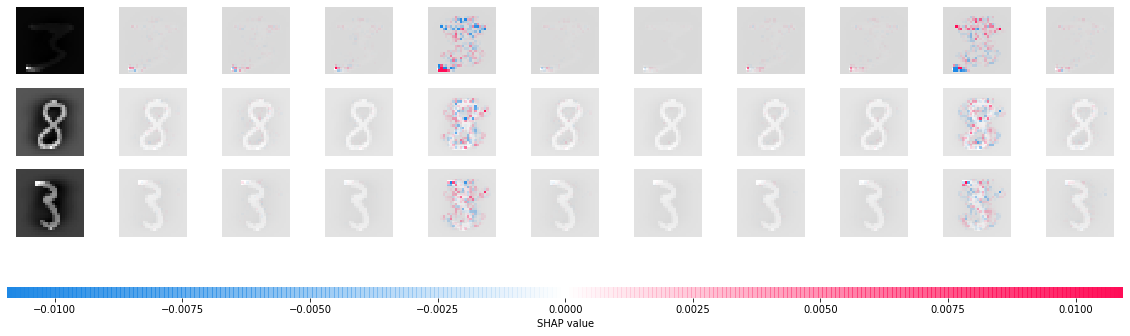

In [44]:
shap.image_plot([shap_values[i][0] for i in range(10)], X_test[:3])

In [12]:
def select_based_on_uncertainity_from_unlabeled(unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
        
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    ulabelled_X = np.array((np.array(ulabelled_X).reshape(len(ulabelled_X),28,28,1)))
    predictions = clf.predict([ulabelled_X,ulabelled_X])
    #print(predictions[0][3])
    for i in range(batch_size):
        predictions_label_wise=np.array(predictions)
        uncertainity_list = list(1-predictions_label_wise.max(axis=1))
        max_index = uncertainity_list.index(max(uncertainity_list))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        modified_u = unlabelled_list
    
    print(len(del_s))
    print(len(modified_u))
    return del_s, modified_u

In [13]:
X_train, y_train, X_test, y_test = getMNIST()

60000
10000


In [169]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
niters = 5

max_uncertainity_accuracies = []
seed_set_size = []

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    x_seed = []
    y_seed = []

    for i in range(len(s)):
        x_seed.append(s[i][0])
        y_seed.append(s[i][1])

    x_seed = np.array(x_seed).reshape(len(x_seed),28,28,1)
    x_seed = x_seed.astype(float)
    
    y_seed = np.array(y_seed).reshape(len(y_seed),)
    y_seed = y_seed.astype(float)
    
    X_test = np.array(X_test).reshape(len(X_test),28,28,1)
    X_test = X_test.astype(float)
    y_test = np.array(y_test).reshape(len(y_test),)
    y_test = y_test.astype(float)
    clf, accuracy = train(x_seed, y_seed, X_test, y_test)
    predictions = clf.predict([X_test, X_test])
    #print(np.argmax(predictions, axis=1))
    del_s, u = select_based_on_uncertainity_from_unlabeled(u, batch_size, clf)
    s = s + del_s
        
    final_s = s

Getting MNIST 3/8 classification data...
3/8 Training set size = 11966
3/8 Test set size = 2000
Initial Seed set size = 100
Unlabelled dataset size = 11866
|S|_0 = 100, |U|_0 = 11866
Train on 100 samples
100/100 [==============================] - 1s 11ms/sample - loss: 1.2587 - accuracy: 0.5000
=======Evaluation========
0.6064340233802795
Accuracy on Test Set: 81.19999766349792 %
50
11816
|S|_1 = 150, |U|_1 = 11816
Train on 150 samples
150/150 [==============================] - 1s 3ms/sample - loss: 1.0138 - accuracy: 0.6467
=======Evaluation========
0.2250428364276886
Accuracy on Test Set: 91.64999723434448 %
50
11766
|S|_2 = 200, |U|_2 = 11766
Train on 200 samples
200/200 [==============================] - 1s 4ms/sample - loss: 0.7609 - accuracy: 0.7100
=======Evaluation========
0.2133241022825241
Accuracy on Test Set: 92.94999837875366 %
50
11716
|S|_3 = 250, |U|_3 = 11716
Train on 250 samples
250/250 [==============================] - 1s 3ms/sample - loss: 0.6461 - accuracy: 0.7520

In [54]:
print(len(final_s))

X_seed=[]
y_seed=[]

for tup in final_s:
    #print(tup[0].shape)
    X_seed.append(tup[0])
    y_seed.append(tup[1])

X_seed = np.array(X_seed).reshape(len(X_seed),28,28,1)
y_seed = np.array(y_seed).reshape(len(y_seed),)
        
print(len(X_seed))  
X_test = np.array(X_test).reshape(len(X_test),28,28,1)
y_test = np.array(y_test).reshape(len(y_test),)

import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(clf, [X_seed, X_seed])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([X_seed,X_seed])

10
10


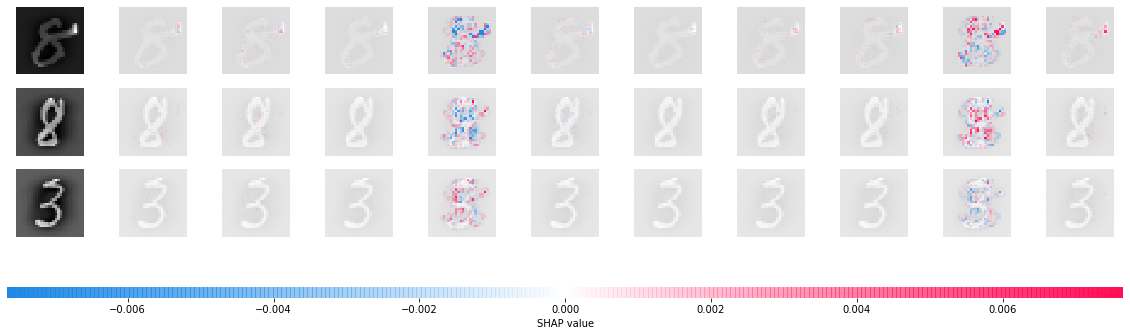

In [55]:
shap.image_plot([shap_values[i][0] for i in range(10)], X_seed[:3])

In [92]:
X_train, y_train, X_test, y_test = getMNIST()

60000
10000


In [93]:
import shap

def select_based_on_explanation_from_unlabeled(seed_list, unlabelled_list, batch_size, clf):
    #print(len(seed_list))
    #print(len(unlabelled_list))
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    ulabelled_X = np.array(ulabelled_X).reshape(len(ulabelled_X),28,28,1)
    ulabelled_y = np.array(ulabelled_y).reshape(len(ulabelled_y),)
    
    
    seed_X=[]
    seed_y=[]

    for tup in seed_list:
        seed_X.append(list(tup[0]))
        seed_y.append(list(tup[1]))
    
    seed_X = np.array(seed_X).reshape(len(seed_X),28,28,1)
    seed_y = np.array(seed_y).reshape(len(seed_y),)
    
    explainer = shap.GradientExplainer(clf, [seed_X, seed_X])
    shap_values_seed = explainer.shap_values([seed_X, seed_X])
    
    #print(list(seed_y)[0])
    from matplotlib import pyplot as plt
    #plt.imshow(list(seed_X.reshape(len(seed_X), 28, 28))[0], cmap='gray')
    #plt.imshow()
    
    #predictions = clf.predict([X_test, X_test])
    predictions_seed = np.argmax(clf.predict([seed_X, seed_X]), axis=1)
    predictions_unlabelled = np.argmax(clf.predict([ulabelled_X, ulabelled_X]), axis=1)
    
    
    explainer = shap.GradientExplainer(clf, [ulabelled_X, ulabelled_X])
    shap_values_unlabelled = explainer.shap_values([ulabelled_X, ulabelled_X])
    
    vectors = np.empty([1, 784])
    for i in range(len(predictions_seed)):
        pred_label = predictions_seed[i]
        print(pred_label)
        np.append(vectors, shap_values_seed[int(pred_label)][1][i].reshape(1,784)[0], axis=None)
        #print(shap_values_seed[int(pred_label)][1][i].reshape(1,784))
        #plt.imshow(shap_values_seed[int(pred_label)][1][i].reshape(28,28), cmap='gray')
        #plt.show()
        
    seed_mean = np.mean(vectors, axis=0).reshape(1,784)[0]
    print("Seed_mean="+str(seed_mean.shape))
    
    sums=[]
    vectors = np.empty([1, 784])
    for i in range(len(predictions_unlabelled)):
        #print("==unlabelled==")
        pred_label = predictions_unlabelled[i]
        #print(pred_label)
        shap_value = shap_values_unlabelled[int(pred_label)][1][i].reshape(1,784)[0]
        #print(shap_value.shape)
        sums.append(np.sum(np.subtract(seed_mean, shap_value)))
        
    print(sums)
    
    del_s = []
    for i in range(batch_size):
        max_index=sums.index(max(sums))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        del sums[max_index]
        
    return del_s, unlabelled_list


In [94]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 4
niters = 3

max_uncertainity_accuracies = []
seed_set_size = []

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    x_seed = []
    y_seed = []

    for i in range(len(s)):
        x_seed.append(s[i][0])
        y_seed.append(s[i][1])

    x_seed = np.array(x_seed).reshape(len(x_seed),28,28,1)
    x_seed = x_seed.astype(float)
    
    y_seed = np.array(y_seed).reshape(len(y_seed),)
    y_seed = y_seed.astype(float)
    
    X_test = np.array(X_test).reshape(len(X_test),28,28,1)
    X_test = X_test.astype(float)
    y_test = np.array(y_test).reshape(len(y_test),)
    y_test = y_test.astype(float)
    clf, accuracy = train(x_seed, y_seed, X_test, y_test)
    #print(np.argmax(predictions, axis=1))
    #select_based_on_explanation_from_unlabeled(s, u, batch_size, clf)
    del_s, u = select_based_on_explanation_from_unlabeled(s, u, batch_size, clf)
    s = s + del_s
        
    final_s = s

Getting MNIST 3/8 classification data...
3/8 Training set size = 11993
3/8 Test set size = 1973
Initial Seed set size = 5
Unlabelled dataset size = 15
|S|_0 = 5, |U|_0 = 15
Train on 5 samples
5/5 [==============================] - 1s 191ms/sample - loss: 2.4877 - accuracy: 0.0000e+00
=======Evaluation========
1.2604116568756296
Accuracy on Test Set: 51.03902816772461 %
3
8
8
3
3
Seed_mean=(784,)
[-169.34614157181227, -169.30434117263442, -169.41951883081438, -169.50209032171534, -169.47474998081685, -169.27282348726206, -169.31416468273946, -169.43001085672395, -169.34922582457617, -169.28783061286913, -169.27387263723418, -169.3980759029446, -169.46560516635057, -169.37724506949675, -169.32818129211856]
|S|_1 = 9, |U|_1 = 11
Train on 9 samples
9/9 [==============================] - 0s 38ms/sample - loss: 2.3883 - accuracy: 0.0000e+00
=======Evaluation========
1.2398388226263062
Accuracy on Test Set: 54.08008098602295 %
3
3
8
3
3
8
3
3
8
Seed_mean=(784,)
[-353.45920150624033, -353.7262

In [95]:
print(len(final_s))

X_seed=[]
y_seed=[]

for tup in final_s:
    #print(tup[0].shape)
    X_seed.append(tup[0])
    y_seed.append(tup[1])

X_seed = np.array(X_seed).reshape(len(X_seed),28,28,1)
y_seed = np.array(y_seed).reshape(len(y_seed),)
        
print(len(X_seed))  
X_test = np.array(X_test).reshape(len(X_test),28,28,1)
y_test = np.array(y_test).reshape(len(y_test),)

import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(clf, [X_test, X_test])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([X_test[:3],X_test[:3]])

17
17


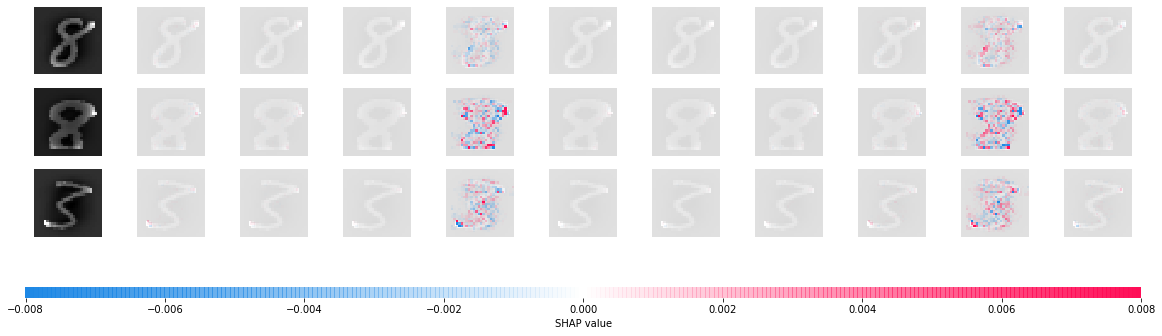

In [96]:
shap.image_plot([shap_values[i][0] for i in range(10)], X_test[:3])

In [9]:
X_train, y_train, X_test, y_test = getMNIST()

60000
10000


In [14]:
import shap

def select_based_on_explanation_from_unlabeled_2(seed_list, unlabelled_list, batch_size, clf, X_test, y_test):
    #print(len(seed_list))
    #print(len(unlabelled_list))
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    ulabelled_X = np.array(ulabelled_X).reshape(len(ulabelled_X),28,28,1)
    ulabelled_y = np.array(ulabelled_y).reshape(len(ulabelled_y),)
    
    print(len(seed_list))
    n_seed_add=2
    
    for i in range(n_seed_add):
        del_s, unlabelled_list = select_based_on_uncertainity_from_unlabeled(unlabelled_list, 1, clf)
        seed_list = seed_list + del_s
    
    print(len(seed_list))
    
    new_x_seed = []
    new_y_seed = []

    for i in range(len(seed_list)):
        new_x_seed.append(seed_list[i][0])
        new_y_seed.append(seed_list[i][1])

    new_x_seed = np.array(new_x_seed).reshape(len(new_x_seed),28,28,1)
    new_x_seed = new_x_seed.astype(float)
    
    new_y_seed = np.array(new_y_seed).reshape(len(new_y_seed),)
    new_y_seed = new_y_seed.astype(float)
    
    X_test = np.array(X_test).reshape(len(X_test),28,28,1)
    X_test = X_test.astype(float)
    y_test = np.array(y_test).reshape(len(y_test),)
    y_test = y_test.astype(float)
    clf2, accuracy = train(new_x_seed, new_y_seed, X_test, y_test)
    new_predictions_seed = np.argmax(clf2.predict([new_x_seed, new_x_seed]), axis=1)
    
    explainer = shap.GradientExplainer(clf2, [new_x_seed, new_x_seed])
    shap_values_seed = explainer.shap_values([new_x_seed, new_x_seed])
    
    vectors = np.empty([1, 784])
    for i in range(len(new_predictions_seed)):
        pred_label = new_predictions_seed[i]
        print(pred_label)
        np.append(vectors, shap_values_seed[int(pred_label)][1][i].reshape(1,784)[0], axis=None)
        
        
    new_seed_mean = np.mean(vectors, axis=0).reshape(1,784)[0]
    print("Seed_mean="+str(new_seed_mean.shape))
    
    
    
    new_ulabelled_X=[]
    new_ulabelled_y=[]
    
    for tup in unlabelled_list:
        new_ulabelled_X.append(list(tup[0]))
        new_ulabelled_y.append(list(tup[1]))
     
    print(len(unlabelled_list))
        
    new_ulabelled_X = np.array(new_ulabelled_X).reshape(len(new_ulabelled_X),28,28,1)
    new_ulabelled_y = np.array(new_ulabelled_y).reshape(len(new_ulabelled_y),)
    
    new_predictions_unlabelled = np.argmax(clf2.predict([new_ulabelled_X, new_ulabelled_X]), axis=1)
    explainer = shap.GradientExplainer(clf2, [new_ulabelled_X, new_ulabelled_X])
    shap_values_unlabelled = explainer.shap_values([new_ulabelled_X, new_ulabelled_X])
    
    sums=[]
    
    vectors = np.empty([1, 784])
    for i in range(len(new_predictions_unlabelled)):
        pred_label = new_predictions_unlabelled[i]
        shap_value = shap_values_unlabelled[int(pred_label)][1][i].reshape(1,784)[0]
        sums.append(np.sum(np.subtract(new_seed_mean, shap_value)))
        
    print(sums)
    
    del_s = []
    for i in range(batch_size):
        max_index=sums.index(max(sums))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        del sums[max_index]
  
    return del_s, unlabelled_list

In [15]:
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

niters = 3

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    x_seed = []
    y_seed = []

    for i in range(len(s)):
        x_seed.append(s[i][0])
        y_seed.append(s[i][1])

    x_seed = np.array(x_seed).reshape(len(x_seed),28,28,1)
    x_seed = x_seed.astype(float)

    y_seed = np.array(y_seed).reshape(len(y_seed),)
    y_seed = y_seed.astype(float)

    X_test = np.array(X_test).reshape(len(X_test),28,28,1)
    X_test = X_test.astype(float)

    y_test = np.array(y_test).reshape(len(y_test),)
    y_test = y_test.astype(float)

    clf, accuracy = train(x_seed, y_seed, X_test, y_test)

    del_s, u = select_based_on_explanation_from_unlabeled_2(s, u, 1, clf, X_test, y_test)
    
    s = s + del_s
        
    final_s = s

3/8 Training set size = 12027
3/8 Test set size = 1939
Initial Seed set size = 5
Unlabelled dataset size = 15
|S|_0 = 5, |U|_0 = 15
Train on 5 samples
5/5 [==============================] - 0s 66ms/sample - loss: 2.5202 - accuracy: 0.0000e+00
=======Evaluation========
0.7967554347732745
Accuracy on Test Set: 56.83342218399048 %
5
1
14
1
13
7
Train on 7 samples
7/7 [==============================] - 0s 58ms/sample - loss: 2.3998 - accuracy: 0.0000e+00
=======Evaluation========
0.6355129008504642
Accuracy on Test Set: 67.6121711730957 %


Using TensorFlow backend.


8
8
3
3
3
8
8
Seed_mean=(784,)
13
[-77.89210404751842, -77.36556214100327, -77.62566278021131, -77.6255170915745, -77.7368523267202, -77.57005414801645, -77.52528237229672, -77.42997712479294, -77.40723125682743, -77.54503620757706, -77.47667001900348, -77.69508485760801, -77.54781455401442]
|S|_1 = 6, |U|_1 = 12
Train on 6 samples
6/6 [==============================] - 0s 76ms/sample - loss: 2.5999 - accuracy: 0.0000e+00
=======Evaluation========
1.0701255889022516
Accuracy on Test Set: 49.7679203748703 %
6
1
11
1
10
8
Train on 8 samples
8/8 [==============================] - 0s 46ms/sample - loss: 2.4991 - accuracy: 0.0000e+00
=======Evaluation========
0.6638147784853301
Accuracy on Test Set: 76.79216265678406 %
8
8
3
3
3
3
8
8
Seed_mean=(784,)
10
[-0.1427215406374387, -0.05161668894277227, -0.23094863880533012, -0.10949972630970706, -0.11896584563783108, -0.07431997180765393, -0.024276383853759853, -0.0729294774491791, -0.04352608206727382, -0.306354097606345]
|S|_2 = 7, |U|_2 = 9
T

In [16]:
print(len(final_s))

X_seed=[]
y_seed=[]

for tup in final_s:
    #print(tup[0].shape)
    X_seed.append(tup[0])
    y_seed.append(tup[1])

X_seed = np.array(X_seed).reshape(len(X_seed),28,28,1)
y_seed = np.array(y_seed).reshape(len(y_seed),)
        
print(len(X_seed))  
X_test = np.array(X_test).reshape(len(X_test),28,28,1)
y_test = np.array(y_test).reshape(len(y_test),)

import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(clf, [X_test, X_test])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([X_test[:3],X_test[:3]])

8
8


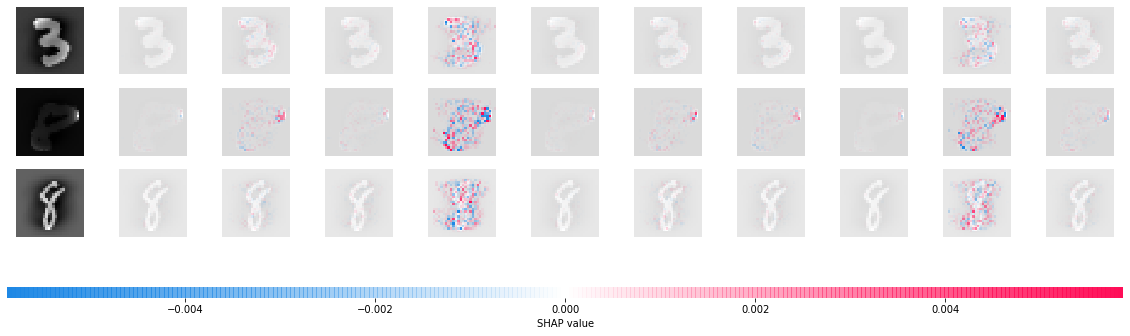

In [17]:
shap.image_plot([shap_values[i][0] for i in range(10)], X_test[:3])